# Tutorial for srfpython

**Overview**
 + Intro : import and verify installation
 + I/ create a 1-D depth model  
 + II/ compute dispersion curves   
     + II.1/ use in a python program  
     + II.2/ use in command line   
 - III/ depth inversion  
 - III.1/ Program HerrMet  
 - III.2/ Application  
     + III.2.1/ Target data  
     + III.2.2/ Parameterization  
     + III.2.3/ Run inversion  
     + III.2.4/ Extract results

## Intro/ import and verify installation

In [1]:
# -----------------------
# import all components of srfpython
# -----------------------
from srfpython import *

In [2]:
# -----------------------
# make sure that the fortran codes have been compiled correctly
# -----------------------
try:
    check_herrmann_codes() 
    print "ok"
    
except Exception:
    print "compilation was not done or done on another system"

    # recompile
    from srfpython import recompile_src90
    recompile_src90(yes=False)

    # verify once more
    try:
        check_herrmann_codes()
        print 'sucess'
    except Exception:
        print 'Error : unexpected failure, make sure you have gfortran installed'



ok


## I/ create a 1-D depth model

In [3]:
# -----------------------
# create 1-D depth model using 4 arrays with same length
# -----------------------
ztop = [0.00, 0.25, 0.45, 0.65, 0.85, 1.05, 1.53, 1.80] #km, top layer depth, positive, increasing downward, 0 = surface
vp   = [1.85, 2.36, 2.63, 3.15, 3.71, 4.54, 5.48, 5.80] #km/s, P wave velocity in each layer
vs   = [0.86, 1.10, 1.24, 1.47, 1.73, 2.13, 3.13, 3.31] #km/s, S wave velocity in each layer
rh   = [2.47, 2.47, 2.47, 2.47, 2.47, 2.58, 2.58, 2.63] #g/cm3, Density in each layer

# create the depthmodel object, use a subclass that is to be intitiated with arrays
# see also depthmodel, depthmodel1D, depthmodel_from_mod96, ...
dm = depthmodel_from_arrays(ztop, vp, vs, rh)


# __str__ returns the file content at mod96 format, (see Herrmann CPS documentation)
print dm 

MODEL.01
ISOTROPIC
KGS
FLAT EARTH
1-D
CONSTANT VELOCITY
LINE08
LINE09
LINE10
LINE11
H(KM) VP(KM/S) VS(KM/S) RHO(GM/CC) QP QS ETAP ETAS FREFP FREFS
0.250000 1.850000 0.860000 2.470000 0.000000 0.000000 0.000000 0.000000 1.000000 1.000000
0.200000 2.360000 1.100000 2.470000 0.000000 0.000000 0.000000 0.000000 1.000000 1.000000
0.200000 2.630000 1.240000 2.470000 0.000000 0.000000 0.000000 0.000000 1.000000 1.000000
0.200000 3.150000 1.470000 2.470000 0.000000 0.000000 0.000000 0.000000 1.000000 1.000000
0.200000 3.710000 1.730000 2.470000 0.000000 0.000000 0.000000 0.000000 1.000000 1.000000
0.480000 4.540000 2.130000 2.580000 0.000000 0.000000 0.000000 0.000000 1.000000 1.000000
0.270000 5.480000 3.130000 2.580000 0.000000 0.000000 0.000000 0.000000 1.000000 1.000000
0.000000 5.800000 3.310000 2.630000 0.000000 0.000000 0.000000 0.000000 1.000000 1.000000



In [4]:
# -----------------------
# write the depth model as a file at mod96 format (see Herrmann CPS documentation)
# -----------------------
dm.write96('dmtuto.mod96')

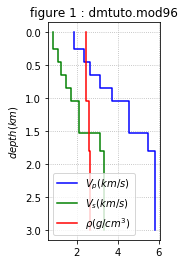

In [5]:
# -----------------------
# display the depth model
# -----------------------
plt.figure(figsize=(2, 4))
dm.show(gca())
gca().set_title('figure 1 : dmtuto.mod96')
gca().grid(True, linestyle=":")
plt.legend();

## II/ compute dispersion curves 

### II.1/ use in a python program

In [6]:
# -----------------------
# use one of the following functions from srfpython.Herrmann.Herrmann
# -----------------------
print help(dispersion)
# print help(dispersion_1)
# print help(dispersion_2)

Help on function dispersion in module srfpython.Herrmann.Herrmann:

dispersion(ztop, vp, vs, rh, waves, types, modes, freqs, h=0.005, dcl=0.005, dcr=0.005)
    compute surface wave dispersion curves from a 1-D depth model
    based on a modified version of the codes from Herrmann and Ammon 2002
    
    *) a dispersion curve is given by 4 attributes
        wave : string, "R" for Rayleigh, "L" for Love
        type : string, "C" for Phase velocity, "U" for Group-velocity
        mode : integer, a mode number, 0 means fundamental
        freq : array, frequencies in Hz
    
    *) a 1-D depth model is given by 4 attributes
        ztop : list or array, sorted, positive, top layer depth in km, ztop[0] must be 0 !!!
        vp   : list or array, P wave velocity in km/s
        vs   : list or array, S wave velocity in km/s
        rh   : list or array, density in g.cm^-3
    
    input:
        -> depth model
        ztop, vp, vs, rh = depth model, 4 iterables with same length
    
       

elapsed time dispersion : 0.031162s


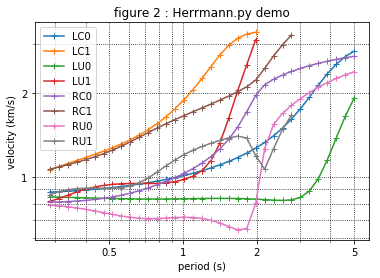

In [7]:
# -----------------------
# compute dispersion curves from the depthmodel above
# -----------------------

# define the dipsersion curves to compute
#          Wave(R/L) Type(C/U) Mode    Frequency array (Hz)             
Curves = [('R',      'U',      0,      freqspace(0.2, 3.5, 35, "log")), 
          ('R',      'U',      1,      freqspace(0.2, 3.5, 35, "log")), 
          ('R',      'C',      0,      freqspace(0.2, 3.5, 35, "log")), 
          ('R',      'C',      1,      freqspace(0.2, 3.5, 35, "log")), 
          ('L',      'U',      0,      freqspace(0.2, 3.5, 35, "log")), 
          ('L',      'U',      1,      freqspace(0.2, 3.5, 35, "log")), 
          ('L',      'C',      0,      freqspace(0.2, 3.5, 35, "log")), 
          ('L',      'C',      1,      freqspace(0.2, 3.5, 35, "log"))] 

# compute dispersion curves
with Timer('dispersion'):
    out = list(dispersion_2(ztop, vp, vs, rh, Curves)) # list is used to iterate over the generator

# display the results
ax = plt.gca()
for w, t, m, fs, us in out:
    ax.loglog(1. / fs, us, '+-', label = "%s%s%d" % (w, t, m))
ax.set_xlabel('period (s)')
ax.set_ylabel('velocity (km/s)')    
ax.grid(True, which = "major")
ax.grid(True, which = "minor")
logtick(ax, "xy")
ax.set_title('figure 2 : Herrmann.py demo')

plt.legend()
plt.show()

### II.2/ use in command line 

In [8]:
# -----------------------
# compute dispersion curves, and save as surf96 file
# -----------------------

import os
os.system('rm -f dmtuto*.surf96')
%run -i ../../srfpython/bin/m96 --disp dmtuto.mod96 \
    -LC0 .1 10 30 plog \
    -RC1 .1 10 30 plog \
    -RU0 .1 10 30 plog \
    -save dmtuto.surf96

# if the srfpython/bin directory was added to the path as stated in README.md, simply use m96, s96, HerrMet, ...

dmtuto.mod96 => dmtuto.surf96


dmtuto.surf96
    Claw wave=L mode=0 type=C flag=T extrapmode=0 N=30
    Claw wave=R mode=1 type=C flag=T extrapmode=1 N=19
    Ulaw wave=R mode=0 type=U flag=T extrapmode=0 N=30


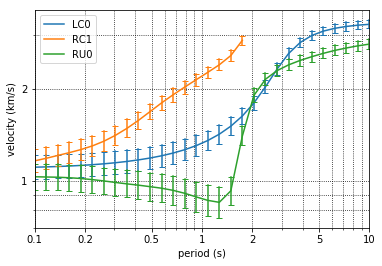

In [9]:
# -----------------------
# display output
# -----------------------

%run -i ../../srfpython/bin/s96 --show dmtuto.surf96 -inline

see also programs **s96** and **m96** that provide more manipulation tools  
for depth models and surface wave dispersion curves in command line

In [10]:
%run -i ../../srfpython/bin/m96 --help

m96
--show            list of mod96 files to display (same plot)
--disp            name of mod96 file to use as input
    -RU0          rayleigh, group, mode 0 : expects 4 frequency arguments : fstart, fend, nfreq, fscale
    -RU1          rayleigh, group, mode 1 : expects 4 frequency arguments : fstart, fend, nfreq, fscale
    -RC0          rayleigh, phase, mode 0 : expects 4 frequency arguments : fstart, fend, nfreq, fscale          
    -LC0          love,     phase, mode 0 : expects 4 frequency arguments : fstart, fend, nfreq, fscale
    ...
    -save         name of surf96file to write
--split 
    -thck         thickness of the sublayers in km
    -sfx          suffix to add before file extension (default split)
    -o            ignore suffix and overwrite input file
--addlayer 
    -thck         thickness of the sublayers in km
    -sfx          suffix to add before file extension (default split)
    -o            ignore suffix and overwrite input file    
-inline           rep

In [11]:
%run -i ../../srfpython/bin/s96 --help

s96
--show            list of surf96files to display
    -freq         plot in frequency domain if specified
--resamp          list of surf96files to resample
    -fspace       new frequency array in Hz, fstart, fend, nfreq, fscale
    -sfx          file suffix to append, use "" to overwrite input files
-inline             replace showme by plt.show (e.g. for jupyter)
#surf96 format 
SURF96 {wave} {type} {flag} {mode} {period(s)} {value(km/s)} {dvalue(km/s)}



## III/ depth inversion

### III.1/ Program HerrMet

In [12]:
%run -i ../../srfpython/bin/HerrMet --help

HerrMet V6.0
# ------- main options (s=string, i=int, f=float)
-version, -v          version number, quit
-help, -h   [s...]    help, provide plugin names for details, quit
-example, -ex s [s..] example usage, provide plugin names for details, quit
-w           i        number of virtual workers, default None
-taskset     s        affinity, e.g. "0-3", default None
-lowprio              run processes with low priority if mentioned
-verbose     i        reduce verbosity, 0/1, default 1
# ------- plugins, use --help plugin [plugin ...] for details
--target     set the target data, create temporary directories (rootnames)
--param      create a template parameterization file
--send       send the parameterization to the temporary directories
--run        invert dispersion data using the Markov Chain Monte Carlo method
--extract    compute and write posterior pdf
--display    display target, parameterization, solutions



In [13]:
%run -i ../../srfpython/bin/HerrMet --help target param send run extract display

--target     s [s..] set the target dispersion curve(s) from surf96 file(s) (not modified)
                     for each target, I create a directory in . for temporary files
                     the data will be reproduced into a target file that can be customized manually
                     (to remove unwanted points, resample dispersion curves...) 
    -resamp  f f i s resample the dispersion curve in the target file, 
                     requires fmin(Hz), fmax(Hz), nfreq, fscale 
                     (flin=linear in freq domain, plin=linear in period or log=logarithmic scaling)
    -lunc    f       set constant uncertainties in log domain (uncertainty = value x lunc)
    -unc     f       set constant uncertainty in linear domain (uncertainty = unc)
    -ot              force overwriting _HerrMet.target if exists
    
--param      i f     generate a template parameter file to custom in .
                     need the number of layers and bottom depth in km
    -basedon s       b

In [14]:
%run -i ../../srfpython/bin/HerrMet -example target param send run extract display  

## TARGET
# get the target dispersion curves, resample it between 0.2-1.5 Hz 
# with 15 samples spaced logarithmically in period domain
# adjust uncertainties to 0.1 in logaritmic domain, 
# overwrite target if exists (_HerrMet.target) 
# and display it

HerrMet --target /path/to/my/data/file.surf96 \
            -resamp 0.2 1.5 15 plog \
            -lunc 0.1 \
            -ot \
            --display
            
# >> you may edit one or more target files (e.g. _HerrMet_t???/_HerrMet.target) 
#    and remove points that 
#    do not need to be inverted, check with  

HerrMet --display _HerrMet_t???
            

## PARAM
# build parameter file from existing depthmodel,
# use 4 layers, use parametrization mZVSPRRH, 
# require vp, vs and density to be growing
# overwrite paramfile if exists (_HerrMet_*/_HerrMet.param) and display

HerrMet --param 4 3. \
            -basedon /path/to/my/depthmodel.mod96 \
            -t  mZVSPRRH \
            -growing \
            -op \
            --d

### III.2/ Application

we propose to invert the synthetic data generated in section I (dmtuto.surf96) and compare the inversion result to the actual model used to synthetize the data (i.e. dmtuto.mod96)

In [15]:
# -----------------------
# assert section I was executed
# clear former temporary files from III
# -----------------------

import os, glob
assert os.path.exists("./dmtuto.surf96")

# clean up before running
os.system('rm -rf _HerrMet_*')

# list files in this directory
for _ in glob.iglob('./*'):
    print _, 

./dmtuto.surf96 ./tutorial.ipynb ./dmtuto.mod96 ./readme.txt


#### III.2.1/ Target data

writing _HerrMet_dmtuto/_HerrMet.target
please keep only datapoints to invert in */_HerrMet.target
use option --display to see the target data
_HerrMet_dmtuto/_HerrMet.target
    Claw wave=L mode=0 type=C flag=T extrapmode=0 N=7
    Claw wave=R mode=1 type=C flag=T extrapmode=1 N=3
    Ulaw wave=R mode=0 type=U flag=T extrapmode=0 N=7


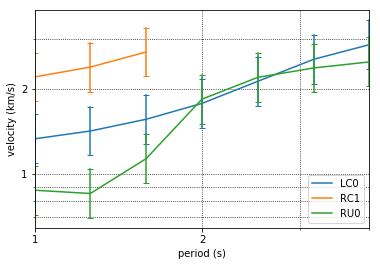

call option --param to see prior depth boundaries


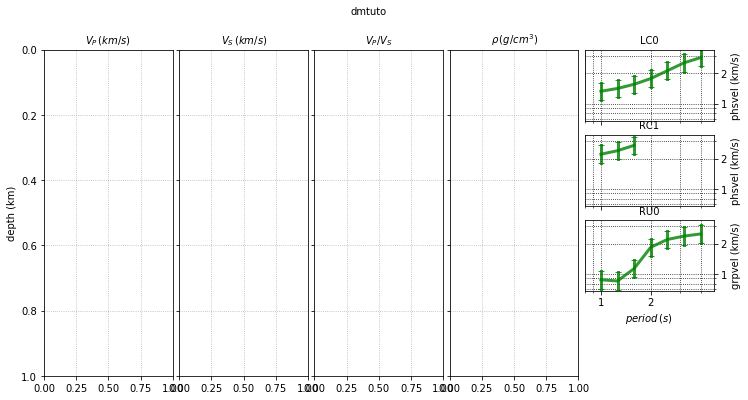

In [16]:
# -----------------------
# set the dispersion curves to invert referred to as the target data
# the dispersion curve must be provided as surf96 format (see Herrmann's doc, CPS)
# I reproduce the file content into _Herrmann.target (also at surf96 format), 
# which can be modified manually before inversion 
# (e.g. resample, remove data points or modes, adjust uncertainties for weighting, ...)
# -----------------------

# the following command will (see HerrMet --help for command names): 
# - get the target dispersion curves from dmtuto.surf96 (--target), 
# - resample it between 0.25-1 Hz with 7 samples spaced logarithmically in period domain (-resamp),
# - adjust the uncertainties to 0.2 * velocity (i.e. constant uncertainty in logaritmic domain, --lunc), 
# - overwrite the target file if exists (-ot) 

%run -i ../../srfpython/bin/HerrMet \
    --target dmtuto.surf96 \
        -resamp 0.25 1.0 7 plog \
        -lunc 0.2 \
        -ot
            
# display the target file with s96 (-inline avoids the program to pause)
%run -i ../../srfpython/bin/s96 --show _HerrMet_dmtuto/_HerrMet.target -inline

# or directly with HerrMet (--display)
%run -i ../../srfpython/bin/HerrMet \
    --display \
        -inline

#### III.2.2/ Parameterization

#met DRHMIN = 0.0
#met DPRMAX = 0.0
#met DVPMIN = 0.0
#met DRHMAX = 5.0
#met DVPMAX = 5.0
#met DVSMAX = 5.0
#met DPRMIN = -5.0
#met PRIORTYPE = 'DVPDVSDRHDPR'
#met NLAYER = 4
#met TYPE = 'mZVSPRRH'
#met DVSMIN = 0.0
#fld KEY VINF VSUP
#unt - - -
#fmt %5s %16f %16f
       -Z1        -0.217990        -0.217990
       -Z2        -0.895334        -0.895334
       -Z3        -3.000000        -3.000000
       VS0         1.111553         1.111553
       VS1         1.577859         1.577859
       VS2         3.071242         3.071242
       VS3         3.310000         3.310000
       PR0         2.143200         2.143200
       PR1         2.136603         2.136603
       PR2         1.800138         1.800138
       PR3         1.752266         1.752266
       RH0         2.470000         2.470000
       RH1         2.485482         2.485482
       RH2         2.614447         2.614447
       RH3         2.630000         2.630000

please customize _HerrMet.param, do not change line orders 

/home/max/anaconda3/envs/tetedenoeud/lib/python2.7/site-packages/matplotlib/axes/_base.py:2961: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=1.0, right=1.0
  'left=%s, right=%s') % (left, right))
/home/max/anaconda3/envs/tetedenoeud/lib/python2.7/site-packages/matplotlib/axes/_base.py:3285: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  'bottom=%s, top=%s') % (bottom, top))


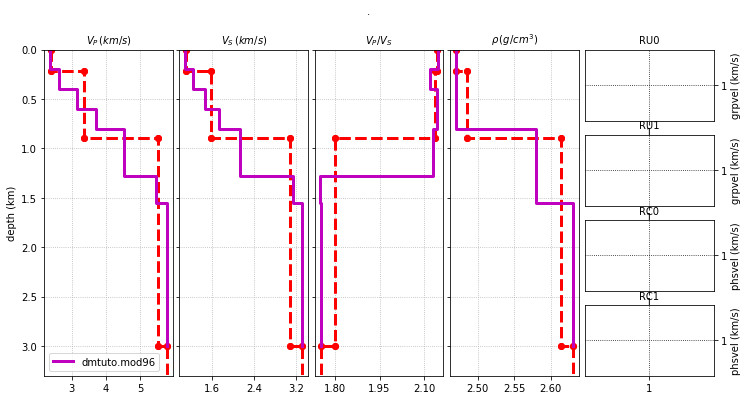

In [17]:
# -----------------------
# set the parameter file, the parameters will be stored into _Herrmet.param
# use Herrmet to generate a template version
# and customize it manually before running the inversion
# -----------------------

# the following command will :
# - set the parameter file with 4 layers down to 3 km (--param)
# - the parameters values will be adjusted based on an existing depthmodel (here dmtuto.mod96, -basedon),
# - define the parameterization mode as depth, vs, vp/vs and density (-t mZVSPRRH)
#   some other modes are available
# - require vp, vs and density to be growing (i.e. add prior constraints to the offsets between layers, -growing),             
# - overwrite the paramfile if exists (-op) 
# - display (-display) without pausing (-inline), plot also the actual model (-m96)

%run -i ../../srfpython/bin/HerrMet \
        --param 4 3. \
            -basedon dmtuto.mod96 \
            -t  mZVSPRRH \
            -growing \
            -op \
        --display . \
            -m96 dmtuto.mod96 \
            -inline

> red dashed curves = prior boundaries (locked for now)   
> green duspersion curves = target data  
> purple model = actual model used to generate the synthetic data and to build the parameterization    

> * Note that at this step, the boundaries for each parameter (red dashed curves)   
> are the same (because VINF=VSUP in _HerrMet.param) : i.e. all parameters are locked  
> one need to adjust the VINF, VSUP boundaries for all parameters to invert  
> you may do it manually (edit _HerrMet.param),   
> here I do it with programming tools for tutorial  


> * Note also that VP is not a parameter in this example, (since we use VS and VP/VS)  
> so the boundaries displayed on the VP axis are inferred from the VS and VP/VS ones
>


In [18]:
# -----------------------
# customize the parameterization file using programming tools (for tutorial)
# You may do it manually simply by editing _Herrmet.param
# -----------------------

#load the parameter file, find lines related to top depth and to VS
from tetedenoeud import AsciiFile
A = AsciiFile('_HerrMet.param')

IZ  = np.asarray(["Z"  in _ for _ in A['KEY']], bool) #lines corresponding to Z parameters
IVS = np.asarray(["VS" in _ for _ in A['KEY']], bool) #lines corresponding to VS parameters
IPR2 = np.asarray(["PR2" in _ for _ in A['KEY']], bool) #line corresponding to VP/VS in the third layer

In [19]:
# change parameter boundaries (decrease VINF and increase VSUP), overwrite _HerrMet.param
A['VINF'][IVS] = [0.55, 0.78, 1.53, 1.65]
A['VSUP'][IVS] = [2.22, 3.15, 4.00, 4.00]
A['VINF'][IZ]  = [-.31, -1.5, -3.1]
A['VSUP'][IZ]  = [-.11, -1.1, -2.0]
A['VINF'][IPR2] = A['VSUP'][IPR2] = 1.752
print A

# overwrite the parameterization file
A.write('_HerrMet.param')

#met DRHMIN = 0.0
#met DPRMAX = 0.0
#met DVPMIN = 0.0
#met DRHMAX = 5.0
#met DVPMAX = 5.0
#met DVSMAX = 5.0
#met DPRMIN = -5.0
#met PRIORTYPE = 'DVPDVSDRHDPR'
#met NLAYER = 4
#met TYPE = 'mZVSPRRH'
#met DVSMIN = 0.0
#fld KEY VINF VSUP
#unt - - -
#fmt %5s %16f %16f
       -Z1        -0.310000        -0.110000
       -Z2        -1.500000        -1.100000
       -Z3        -3.100000        -2.000000
       VS0         0.550000         2.220000
       VS1         0.780000         3.150000
       VS2         1.530000         4.000000
       VS3         1.650000         4.000000
       PR0         2.143200         2.143200
       PR1         2.136603         2.136603
       PR2         1.752000         1.752000
       PR3         1.752266         1.752266
       RH0         2.470000         2.470000
       RH1         2.485482         2.485482
       RH2         2.614447         2.614447
       RH3         2.630000         2.630000



In [20]:
# -----------------------
# send the custom version of the parameterization file to the temporary directory
# -----------------------
%run -i ../../srfpython/bin/HerrMet --send

cp ./_HerrMet.param _HerrMet_dmtuto/


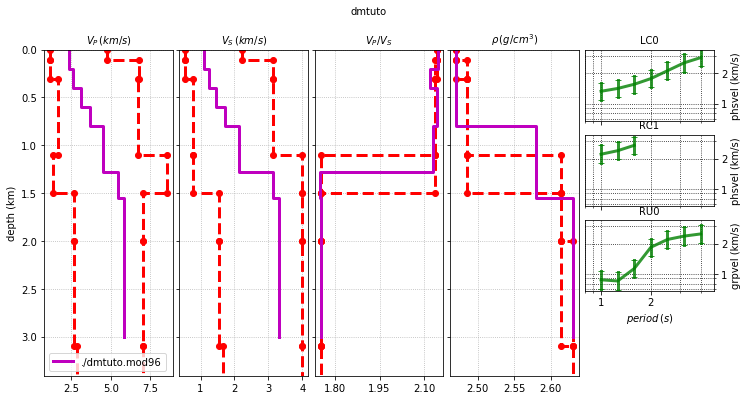

In [21]:
# -----------------------
# display the new version of the parameterization file
# -----------------------

#note that the boundaries now allow VS and Zop to vary between the red dashed lines
%run -i ../../srfpython/bin/HerrMet \
    --display \
        -inline \
        -m96 ./dmtuto.mod96

#### III.2.3/ Run inversion

In [22]:
# -----------------------
# run the inversion, will load the parameterization and target data,
# and generate markov chains to sample the posterior pdf (in parallel)
# the models generated by the chains will be stored in a sqlite database (_HerrMet.run)
# -----------------------

# the following command will :
# - run the inversion with 12 markov chains in restart mode (overwrites _HerrMet.run if exists)
# - each chain will be asked to keep 100 models
# - use 4 virtual threads (-w) affected to the first 4 physical threads (-taskset)
%run -i ../../srfpython/bin/HerrMet \
    -w 4 -taskset "0-3" \
    --run \
        -nchain 12 \
        -nkeep 100 \
        -verbose 0
        
# notations :
# kept : the number of models kept by the markov chain over the number of tests
# fail : some models can lead to failure of the forward algo (CPS), 
#        we consider them as models with no image in the dataspace
#        the penalty is adjusted to force the chains to move away from these dead ends
# AK   : Average keep ratio : the number of models kept / the number of tests
#        by default, the proposal pdf is adjusted to maintain this value around .25
# MP   : Master proposal : a coefficient to adjust the proposal distance according to AK
# AS   : Average speed : the average number of models tested per second and per chain
# LI   : Final log likelyhood = the quality of the last model found (not necessarily the best)

    dmtuto chain    1  DONE kept  100/  479 fail   11 AK 0.21 MP 0.52 AS  74.21/s LI -1.568487
    dmtuto chain    3  DONE kept  100/  507 fail   10 AK 0.19 MP 0.38 AS  73.99/s LI -3.708358
    dmtuto chain    2  DONE kept  100/  531 fail   17 AK 0.18 MP 0.33 AS  76.02/s LI -5.080380
    dmtuto chain    0  DONE kept  100/  556 fail   19 AK 0.18 MP 0.28 AS  75.01/s LI -6.087447
    dmtuto chain    4  DONE kept  100/  490 fail   21 AK 0.20 MP 0.45 AS  76.85/s LI -2.705166
    dmtuto chain    5  DONE kept  100/  553 fail   30 AK 0.18 MP 0.29 AS  76.81/s LI -4.993606
    dmtuto chain    6  DONE kept  100/  561 fail   27 AK 0.17 MP 0.26 AS  76.76/s LI -3.756083
    dmtuto chain    7  DONE kept  100/  537 fail   20 AK 0.18 MP 0.33 AS  73.74/s LI -3.023166
    dmtuto chain    8  DONE kept  100/  554 fail   51 AK 0.18 MP 0.28 AS  81.01/s LI -8.457194
    dmtuto chain   10  DONE kept  100/  457 fail   17 AK 0.21 MP 0.57 AS  74.82/s LI -6.754109
    dmtuto chain    9  DONE kept  100/  520 fail  

top : llkmin 0.000000, limit 200, step 1 retrieved 200 models in 0.134385s 
pdf : llkmin 0.000000, limit 0, step 1 retrieved 1212 models in 0.310294s 
Stacker Worker-0007 stacked    127 jobs in 0.104188s
Stacker Worker-0005 stacked    141 jobs in 0.113776s
Stacker Worker-0004 stacked    146 jobs in 0.115282s
Stacker Worker-0006 stacked    141 jobs in 0.111787s
Stacker Worker-0001 stacked    170 jobs in 0.130062s
Stacker Worker-0008 stacked    147 jobs in 0.108360s
Stacker Worker-0003 stacked    148 jobs in 0.120993s
Stacker Worker-0002 stacked    192 jobs in 0.151838s


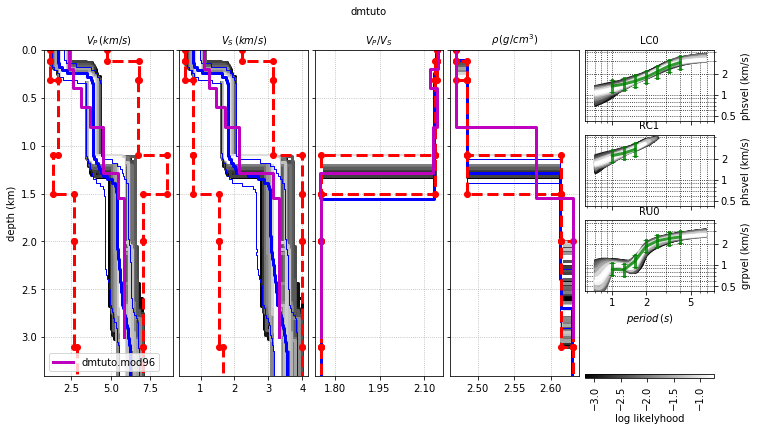

In [23]:
# -----------------------
# display the results, by selecting models in the sqlite database (_HerrMet.run)
# -----------------------

# the following command will :
# - display the best 200 models found and their image in the dataspace (-top)
# - recompute the dispersion curves with higher resolution (-overdisp)
# - compute the median and std of the full population of models (-pdf)
# - add the model used to synthetize the data (dmtuto.mod96) for comparison (-m96)
%run -i ../../srfpython/bin/HerrMet \
        --display \
            -top 0 200 1 \
            -overdisp \
            -pdf \
            -verbose 0 \
            -inline \
            -m96 dmtuto.mod96


> red dashed curves = prior boundaries  
> green duspersion curves = target data  

> gray models = 200 best models sorted by increaseing likelyhood (see colorbar)   
> gray dispersion curves = corresponding data, recomputed with higher resolution  

> blue lines = median (thick), 16% 84% percentiles (thin) computed from the full population of models = solution  
> purple model = actual model used to generate the synthetic data = expected solution  


#### III.2.4/ Extract results

In [24]:
# -----------------------
# HerrMet can create figures, 
# however you probably need to get the results at numerical format for further analysis
# use option --extract
# -----------------------

# the following command will:
# -compute the median and std of the best 1000 models found, 
# -save it as mod96 files named 
#     _HerrMet.p0.16.mod96,_HerrMet.p0.50.mod96 and _HerrMet.p0.84.mod96
%run -i ../../srfpython/bin/HerrMet \
    --extract \
        -top 0.0 1000 1 

connecting to        : /home/max/prog/git/srfpython/tutorials/tutorial0/_HerrMet_dmtuto/_HerrMet.run
extract : llkmin 0.000000, limit 1000, step 1 retrieved 1000 models in 0.296516s 
closing              : /home/max/prog/git/srfpython/tutorials/tutorial0/_HerrMet_dmtuto/_HerrMet.run
Stacker Worker-0003 stacked    122 jobs in 0.094197s
Stacker Worker-0004 stacked    132 jobs in 0.099066s
Stacker Worker-0001 stacked    157 jobs in 0.114050s
Stacker Worker-0008 stacked     95 jobs in 0.075410s
Stacker Worker-0007 stacked    111 jobs in 0.087169s
Stacker Worker-0002 stacked    128 jobs in 0.102556s
Stacker Worker-0006 stacked    126 jobs in 0.096613s
Stacker Worker-0005 stacked    129 jobs in 0.108989s
writing _HerrMet_dmtuto/_HerrMet.p0.16.mod96
writing _HerrMet_dmtuto/_HerrMet.p0.50.mod96
writing _HerrMet_dmtuto/_HerrMet.p0.84.mod96


_HerrMet_dmtuto/_HerrMet.p0.16.mod96
_HerrMet_dmtuto/_HerrMet.p0.50.mod96
_HerrMet_dmtuto/_HerrMet.p0.84.mod96
dmtuto.mod96


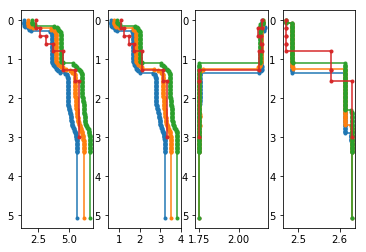

In [25]:
#display models from --extract using m96
%run -i ../../srfpython/bin/m96 --show _HerrMet_*/_HerrMet.p*.mod96 dmtuto.mod96 -inline

In [26]:
# clear temporary files
os.system('rm -rf dmtuto.*96 _HerrMet*')
for _ in glob.iglob('./*'):
    print _,

./tutorial.ipynb ./readme.txt
